In [2]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [6]:
channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray TRANS diode to PRIME Keysight (channel 1)
channel_PIPS_fluo = "SARES11-GES1:CH2_VAL_GET/data"            #X-ray FLUO diode to PRIME Keysight (channel 2)
channel_Izero = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)

channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
channel_PALM_drift = "SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift

In [29]:
def LoadData_YAG(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = pulse_ids%4 == 0  
        reprate_laser = ((pulse_ids%2 == 0) & (pulse_ids%4 != 0))           #This is for 50 Hz  
        
        LaserDiode_pumped = BS_file[channel_LaserDiode][reprate_FEL]
        LaserDiode_unpumped = BS_file[channel_LaserDiode][reprate_laser]
        Izero_pump = BS_file[channel_Izero][reprate_FEL]
        Izero_unpumped = BS_file[channel_Izero][reprate_laser]
        PIPS = BS_file[channel_PIPS_trans][reprate_FEL]
        LaserRefDiode = BS_file[channel_Laser_refDiode][reprate_laser]
        Delay = BS_file[channel_delay][reprate_laser]
        
    return LaserDiode_pumped, LaserDiode_unpumped, Izero_pump, Izero_unpumped, PIPS, LaserRefDiode, Delay

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [8]:
DIR = "/sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/"
DIR_json = "/sf/alvra/data/p17569/res/scan_info/"

!ls -lah -rt /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.1G
-rw-r--r--.   1 root  p17569  51M Dec 15 15:05 YAG_0.1_jet_LAMcheck_040_step0000.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:05 YAG_0.1_jet_LAMcheck_040_step0001.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:06 YAG_0.1_jet_LAMcheck_040_step0002.h5
-rw-r--r--.   1 root  p17569  52M Dec 15 15:07 YAG_0.1_jet_LAMcheck_040_step0003.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:08 YAG_0.1_jet_LAMcheck_040_step0004.h5
-rw-r--r--.   1 root  p17569  53M Dec 15 15:08 YAG_0.1_jet_LAMcheck_040_step0005.h5
-rw-r--r--.   1 root  p17569  52M Dec 15 15:09 YAG_0.1_jet_LAMcheck_040_step0006.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:10 YAG_0.1_jet_LAMcheck_040_step0007.h5
-rw-r--r--.   1 root  p17569  52M Dec 15 15:11 YAG_0.1_jet_LAMcheck_040_step0008.h5
-rw-r--r--.   1 root  p17569  52M Dec 15 15:11 YAG_0.1_jet_LAMcheck_040_step0009.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:12 YAG_0.1_jet_LAMcheck_040_step0010.h5
-rw-r--r--.   1 root  p17569  51M Dec 15 15:13 YAG_0.1_jet_LAMche

In [10]:
# this cell just to test if the channels are read correctly, you can skip it.

fileName = "YAG_0.1_jet_LAMcheck_040_step0000.h5"

BS_file = h5py.File(DIR + fileName)
#print(list(BS_file["data"].keys()))

Laser_diode = BS_file[channel_LaserDiode]

In [25]:
scan_name ="YAG_0.1_jet_LAMcheck_040"

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Laser_pumped = []
err_laser_pumped = []
Laser_unpumped = []
err_laser_unpumped = [] 
Izero_pumped = []
err_Izero_pumped = []
Izero_unpumped = []
err_Izero_unpumped = []
PIPS = []
Laser_ref = []
Delay_mm = []

for i in range(0,numFiles):
    print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
    (Laser_pumped_loop,Laser_unpumped_loop,Izero_pumped_loop,Izero_unpumped_loop,PIPS_loop,Laser_ref_loop,delay_loop) = LoadData_YAG(str(data['scan_files'][i][0]))
    Laser_pumped.append(Laser_pumped_loop.mean())
    err_laser_pumped.append(Laser_pumped_loop.std()/np.sqrt(Laser_pumped_loop.size))
    Laser_unpumped.append(Laser_unpumped_loop.mean())
    err_laser_unpumped.append(Laser_unpumped_loop.std()/np.sqrt(Laser_unpumped_loop.size))
    Izero_pumped.append(Izero_pumped_loop.mean())
    err_Izero_pumped.append(Izero_pumped_loop.std()/np.sqrt(Izero_pumped_loop.size))
    Izero_unpumped.append(Izero_unpumped_loop.mean())
    err_Izero_unpumped.append(Izero_unpumped_loop.std()/np.sqrt(Izero_unpumped_loop.size))
    PIPS.append(PIPS_loop.mean())
    Laser_ref.append(Laser_ref_loop.mean())
    Delay_mm.append(delay_loop.mean())
    
Laser_pumped = np.asarray(Laser_pumped)
err_laser_pumped = np.asarray(err_laser_pumped)
Laser_unpumped = np.asarray(Laser_unpumped)
err_laser_unpumped = np.asarray(err_laser_unpumped)
Izero_pumped = np.asarray(Izero_pumped)
err_Izero_pumped = np.asarray(err_Izero_pumped)
Izero_unpumped = np.asarray(Izero_unpumped)
err_Izero_unpumped = np.asarray(err_Izero_unpumped)
Delay_mm = np.asarray(Delay_mm)

/sf/alvra/data/p17569/res/scan_info/YAG_0.1_jet_LAMcheck_040_scan_info.json
Processing 21 files
step 1 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0000.h5
step 2 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0001.h5
step 3 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0002.h5
step 4 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0003.h5
step 5 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0004.h5
step 6 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0005.h5
step 7 of 21 : Processing /sf/alvra/data/p17569/res/scan_data/YAG_0.1_jet_LAMcheck_040/YAG_0.1_jet_LAMcheck_040_step0006.h5
step 8 of 21 : Processing /sf/alvra/

In [26]:
print (Laser_pumped_loop.shape, Laser_unpumped_loop.shape)

(250,) (250,)


In [27]:
laser_pumped_norm = Laser_pumped / Izero_pumped
err_laser_pumped_norm = err_laser_pumped / Izero_pumped
laser_unpumped_norm = Laser_unpumped / Izero_unpumped
err_laser_unpumped_norm = err_laser_unpumped / Izero_unpumped

laser_diff = -np.log10(laser_pumped_norm / laser_unpumped_norm) 
Delay_ps = (Delay_mm - 150)*3.333   # factor of 2 in delay due to the delay stage is considered below.
# here to add the time zero value

<IPython.core.display.Javascript object>


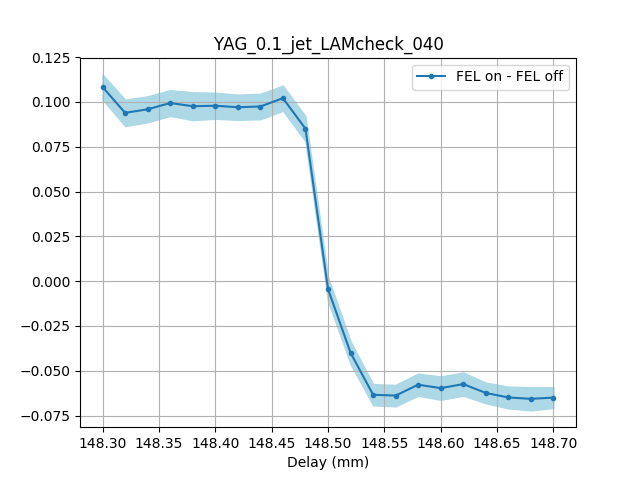

In [28]:
# Plot pump probe signal as a function of delay (stage mm)

#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure()
plt.plot(Delay_mm, laser_diff, label="FEL on - FEL off",marker='.')

low_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) - (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
high_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) + (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')
plt.title("YAG_0.1_jet_LAMcheck_040")
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig(savedir + 'LAMcheck_026')

<IPython.core.display.Javascript object>


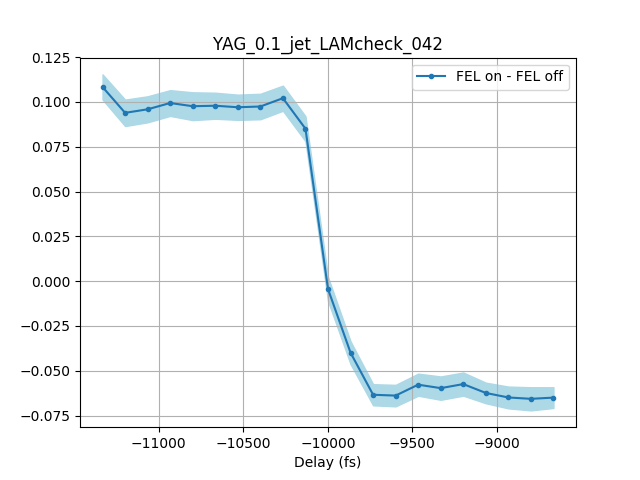

In [30]:
# Plot pump probe signal as a function of time (fs)

#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure()
plt.plot((2*Delay_ps)*1000, laser_diff, label="FEL on - FEL off",marker='.')

low_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) - (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
high_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) + (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
plt.fill_between(np.squeeze((2*Delay_ps)*1000), low_err, high_err, color='lightblue')

plt.title("YAG_0.1_jet_LAMcheck_042")
plt.xlabel("Delay (fs)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig('Timescan_7_diode')

In [19]:
Delay_mm_2 = Delay_mm.copy()
Delay_ps_2 = Delay_ps.copy()
laser_diff_2 = laser_diff.copy()

<IPython.core.display.Javascript object>


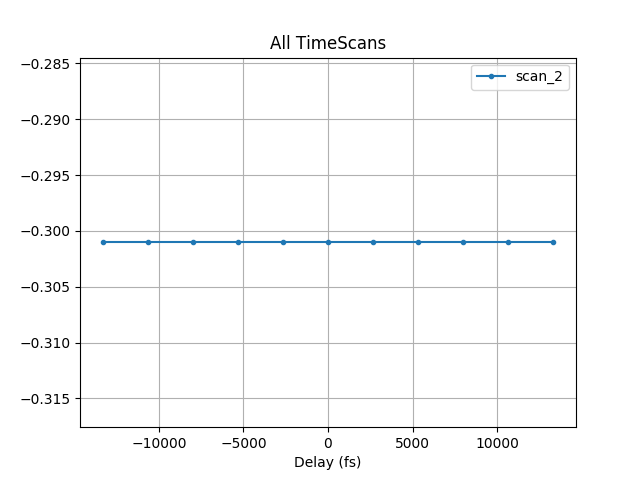

In [22]:
# Plot several scans on the same left axis as a function of time delay (fs)

#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure()

#plt.plot((2*Delay_ps_1)*1000, laser_diff_1,label="scan_1", marker='.')
plt.plot((2*Delay_ps_2)*1000, laser_diff_2,label="scan_2", marker='.')
#plt.plot((2*Delay_ps_3)*1000, laser_diff_3,label="scan_3", marker='.')

plt.title("All TimeScans")
plt.xlabel("Delay (fs)")
plt.legend(loc="best")
#plt.xlim([-1500, 1500])
plt.grid()
plt.show()
#plt.savefig('Timescans_all_diode')

In [ ]:
# Plot scans on two axis (left [ax1] and right [ax2]) as a function of stage position (mm)

#Left axis:
fig, ax1 = plt.subplots()
ax1.plot(Delay_mm_2, laser_diff_2,label="scan_2", marker='.')
ax1.legend(loc="lower left")

#Right axis:
ax2 = ax1.twinx()

ax2.plot(Delay_mm_1 laser_diff_1label="scan_1", marker='.', color = 'y')
ax2.legend(loc=0)

#plt.xlim([155.3, 155.7])
plt.title("All TimeScans")
plt.xlabel("Delay (mm)")

plt.grid()
plt.show()

#plt.savefig('Timescans_all_diode')

In [ ]:
# Now fit with error funciton (defined above)
parameters,extras = curve_fit(errfunc, Delay_mm_2, laser_diff_2, p0 = [0.10, 10, 155.5, -0.1])

print("Position t0 =",np.abs(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

In [ ]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Delay_mm_2, laser_diff_2, label="scan_002",marker='.')
plt.plot(Delay_mm_2, errfunc(Delay_mm_2,*parameters))

#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

#plt.fill_between(position, low_err, high_err, color='lightblue')
plt.title(np.round(parameters[2], 3) )
plt.grid()
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.show()
plt.savefig(savedir + 'scan_LAM_003')

## Next cell  just to calculate time zero 

In [24]:
time_zero = 148.463            #this is in mm from the delay scans

desidered_delay = 2           #choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

To be at 2 ps, put the laser pump delay stage to 148.7633 mm
